In [1]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pickle
import os
import time

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

In [2]:
from sklearn.cross_validation import KFold
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing

In [3]:
os.chdir('../')

In [4]:
import params
import make_dictionaries

source_directory = params.source_directory
full_sample = 'full_sample_debiased.fits'

In [5]:
questions = make_dictionaries.questions
print('Loaded questions...')
function_dictionary = make_dictionaries.function_dictionary
print('Loaded functions...')

Loaded questions...
Loaded functions...


In [6]:
debiased_data = Table.read('../fits/' + full_sample)
print('Loaded galaxy data...')
in_volume_limit = debiased_data['in_volume_limit'] == True
in_mass_limit = debiased_data['LOGMSTAR_BALDRY06'] > 10.6
vl_data = debiased_data[(in_volume_limit)]
ml_data = debiased_data[(in_volume_limit) & (in_mass_limit)]

Loaded galaxy data...


In [7]:
colors = ['r','b','g','y']
colors_long = ['orange','r','magenta','g','blue','cyan','k']

In [8]:
def reduce_sample(full_data,questions,question,p_cut=0.5,N_cut=5,normalised_values=True):
    
    # Get the reference sample from the previous data:
    
    previous_q = questions[question]['pre_questions']
    previous_a = questions[question]['pre_answers']
    
    if normalised_values == True:
        suffix = '_debiased_rh_normalised'
    else:
        suffix = '_debiased_rh'
    
    if previous_q != None:
        
        p_col = np.ones(len(full_data))
        
        for m in range(len(previous_q)):
            p_col = p_col*(full_data[previous_q[m] + '_' + previous_a[m] + suffix])
        N_col = (full_data[previous_q[-1] + '_' + previous_a[-1] + '_count'])
        
        select = (p_col > p_cut) & (N_col >= N_cut)
        data_reduced = full_data[select]
        print('{}/{} galaxies with p>{} and N>={}.'.format(len(data_reduced),
                                                          len(full_data),p_cut,N_cut))
    
    else:
        data_reduced = full_data.copy()
        select = np.ones(len(full_data)) == 1
        print('Primary question, so all {} galaxies used.'.format(len(data_reduced)))
    
    return data_reduced,select


def get_spirals_and_assignments(full_data,question_dictionary,th=None):
    
    data,select = reduce_sample(full_data,question_dictionary,'t11_arms_number')
    answers = question_dictionary['t11_arms_number']['answers']

    remove_ct = data['t04_spiral_a08_spiral_count'] - data['t11_arms_number_a37_cant_tell_count'] >= 5
    # remove any gals where most votes are for can't tell
    in_volume_limit = data['in_volume_limit'] == 1
    
    spirals = data[(remove_ct) & (in_volume_limit)]
    print('{} galaxies with p>0.5 and N>=5'.format(len(spirals)))
    
    arm_answers = ['t11_arms_number_' + A + '_debiased_rh' for A in answers[:-1]]
    arm_array = np.array([spirals[A] for A in arm_answers]).T
    raw_answers = ['t11_arms_number_' + A + '_weighted_fraction' for A in answers[:-1]]
    raw_array = np.array([spirals[A] for A in raw_answers]).T
    
    if th != None:
        select = np.max(arm_array,axis=1) > th
    else:
        select = np.ones(len(spirals)) == 1
    
    arm_assignments = np.argmax(arm_array,axis=1)
    raw_assignments = np.argmax(raw_array,axis=1)
    
    arm_assignments = arm_assignments[select]
    raw_assignmnets = raw_assignments[select]
    spirals = spirals[select]
    redshifts = spirals['REDSHIFT_1']
    
    return spirals,arm_assignments

In [9]:
def preprocess_data(x,y,N_out=100,levels=[0.8,0.6,0.4,0.2],x_range=None,y_range=None,bandwidth='optimal'):
    '''Preprocess the data, so that mean=0 and std=1'''
    
    values = np.array([x,y]).T # Read the x and y data into the correct format.
    
    # First set the x and y ranges if not done so already:
    if x_range == None:
        x_range = [np.min(values[:,0]),np.max(values[:,0])] 
    if y_range == None:
        y_range = [np.min(values[:,1]),np.max(values[:,1])]
        
    # Select values within the specified range:  
    values = values[(values[:,0] >= x_range[0]) & (values[:,0] <= x_range[1])
        & (values[:,1] >= y_range[0]) & (values[:,1] <= y_range[1])]
    
    # Scale the appropriate values:
    values_scaled = preprocessing.scale(values)
    x_range_scaled = [(x_r-np.mean(x))*(1/np.std(x)) for x_r in x_range]
    y_range_scaled = [(y_r-np.mean(y))*(1/np.std(y)) for y_r in y_range]
    
    return values_scaled,x_range_scaled,y_range_scaled

In [10]:
def contour(values,bandwidth,x,y,ax,x_range=None,y_range=None,colour='k',colmap='Greys',filled=False):
    '''Create a contour plot, given a set of values. The values is usually the full table,
       whilst x and y are usually 2 strings corresponding to column names.'''
    
    x_column,y_column = get_columns(values,x,y)
    
    if x_range == None:
        x_range = [np.min(x_column),np.max(x_column)] 
    if y_range == None:
        y_range = [np.min(y_column),np.max(y_column)]
    
    v_scaled,x_scaled,y_scaled = preprocess_data(x_column,y_column,x_range=x_range,y_range=y_range)
    h,v = get_kde(v_scaled,x_scaled,y_scaled,bandwidth) # KDE from obtained bandwidths
    x = np.linspace(x_range[0],x_range[1],100)
    y = np.linspace(y_range[0],y_range[1],100)
    
    ax_l = np.shape(ax)
    
    if len(ax_l) == 1:
    
        for ax0 in ax:
            if filled is True:
                ax0.contourf(x,y,h,levels=np.append(v,np.max(h)),cmap=colmap,zorder=0)
                ax0.contour(x,y,h,levels=v,linewidths=1,colors=colour,zorder=0)
            else:
                ax0.contour(x,y,h,levels=v,linewidths=2,colors=colour,zorder=0.5)
    else:
        if filled is True:
            ax.contourf(x,y,h,levels=np.append(v,np.max(h)),cmap=colmap,zorder=0)
            ax.contour(x,y,h,levels=v,linewidths=1,colors=colour,zorder=0)
        else:
            ax.contour(x,y,h,levels=v,linewidths=2,colors=colour,zorder=0.5)
        
    return None

In [11]:
def get_kde_bandwidth(values,x_range=None,y_range=None,N=10,n_folds=5,num_sigmas=20,plot_values=False):
    '''Use (n_folds) cross-validation to find an idealised bandwidth, given x and y data'''
    
    if len(values) > 5000: # Try to speed up the process for large datasets. 
        # Will need to remove this when making final plots.
        np.random.shuffle(values)
        values = values[:5000]
                   
    params = {'bandwidth': np.logspace(-1,0.3,num_sigmas)}
    kf = KFold(n=len(values),n_folds=n_folds,shuffle=True)
    grid = GridSearchCV(KernelDensity(), params,cv=kf)
    grid.fit(values)
    
    if plot_values:
        gridscores = grid.grid_scores_
        sigmas = np.logspace(-1,0.3,num_sigmas)
        chisq = np.zeros((num_sigmas,1))
        for r in range(num_sigmas):
            chisq[r] = gridscores[r][1]
        plt.plot(sigmas,chisq)
        
    return grid.best_estimator_.bandwidth  


def get_kde(values,x_range,y_range,bandwidth,N_out=100,levels=[0.8,0.6,0.4,0.2]):  
    '''This function calculates an KDE from x and y values, given a bandwidth'''
    
    X = np.linspace(x_range[0],x_range[1],N_out+1)
    Y = np.linspace(y_range[0],y_range[1],N_out+1)
    xy = get_bins(N_out,x_range,y_range)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(values)
    H = np.exp(kde.score_samples(xy).reshape(N_out,N_out))
    # Rest is taken from the triangle.py method of plotting fractional data contours.
    #--------------------------------------------------------------------------------
    Hflat = H.flatten()
    inds = np.argsort(Hflat)[::-1]
    Hflat = Hflat[inds]
    sm = np.cumsum(Hflat)
    sm /= sm[-1]
    V = np.empty(len(levels))
    for i, v0 in enumerate(levels):
        try:
            V[i] = Hflat[sm <= v0][-1]
        except:
            V[i] = Hflat[0]
    #--------------------------------------------------------------------------------
    return H,V


def get_bins(N,x_range,y_range):

    bins_x = np.linspace(x_range[0],x_range[1],N+1)
    bins_y = np.linspace(y_range[0],y_range[1],N+1)
    
    bin_centres_x = np.array([bins_x[B] + (bins_x[B+1]-bins_x[B])/2 for B in range(N)])
    bin_centres_y = np.array([bins_y[B] + (bins_y[B+1]-bins_y[B])/2 for B in range(N)])
    
    xx_centres,yy_centres =  np.meshgrid(bin_centres_x,bin_centres_y)
    xy = np.array([np.ravel(xx_centres),np.ravel(yy_centres)]).T # Used to 'score' the samples.
    
    return xy

In [69]:
def get_column(data,column_name):
    
    if len(column_name) == 2:
        column = data[column_name[0]] - data[column_name[1]]
    else:
        column = data[column_name[0]]
        
    return column


def get_columns(values,x,y):
    
    x_column = get_column(values,x)
    y_column = get_column(values,y)
    finite_values = np.isfinite(x_column) & np.isfinite(y_column)
    x_column = x_column[finite_values]
    y_column = y_column[finite_values]
    
    return x_column,y_column

In [13]:
def get_bandwidth_list(full_table,spirals_table,assignments,
                       x,y,x_range=None,y_range=None,filename='bandwidths'):
    
    '''Return a list of ideal bandwidths using 5-fold CV:
    
    full_table = underplotted reference table
    spirals_table = table of spiral galaxies
    assignments = assigned spiral arm number table (of same length as spirals table)
    x,y = strings for column names
    '''

    start = time.clock()
    bandwidths = np.zeros(6)
    
    x_column_full,y_column_full = get_columns(full_table,x,y)
    x_column,y_column = get_columns(spirals_table,x,y)

    v_scaled,x_scaled,y_scaled = preprocess_data(x_column_full,y_column_full
                                                 ,x_range=x_range,y_range=y_range)
    bandwidths[0] = get_kde_bandwidth(values=v_scaled,x_range=x_scaled,y_range=y_scaled,plot_values=False)

    for m in range(5):
    
        spirals_m = assignments == m
        x_m = x_column[spirals_m]
        y_m = y_column[spirals_m]
        v_scaled,x_scaled,y_scaled = preprocess_data(x_m,y_m,x_range=x_range,y_range=y_range)
        bandwidths[m+1] = get_kde_bandwidth(values=v_scaled,x_range=x_scaled,y_range=y_scaled,plot_values=False)
    
    print('{0:0.1f} seconds in total'.format(time.clock() - start)) # Time it took to plot all of this.
    
    np.save('npy/' + filename + '.npy',bandwidths) # save output files?
    
    return bandwidths

In [14]:
def plot_bandwidth(data,x,y,ax,position,bandwidth,colour='k',linewidth=1,x_range=None,y_range=None):
    
    x_column,y_column = get_columns(data,x,y)
    
    values = np.array([x_column,y_column]).T # Read the x and y data into the correct format.
    
    # First set the x and y ranges if not done so already:
    if x_range == None:
        x_range = [np.min(values[:,0]),np.max(values[:,0])] 
    if y_range == None:
        y_range = [np.min(values[:,1]),np.max(values[:,1])]
        
    # Select values within the specified range:  
    values = values[(values[:,0] >= x_range[0]) & (values[:,0] <= x_range[1])
        & (values[:,1] >= y_range[0]) & (values[:,1] <= y_range[1])]
    
    # Get axis positions
    x_axes = ax.get_xlim()
    y_axes = ax.get_ylim()
    x_pos = x_axes[0] + (x_axes[1]-x_axes[0])*position[0]
    y_pos = y_axes[0] + (y_axes[1]-y_axes[0])*position[1]
    
    # Now get scaled bandwidth:
    x_scaled_bw = bandwidth*np.std(values[:,0])
    y_scaled_bw = bandwidth*np.std(values[:,1])
    ax.hlines(y_pos,x_pos-x_scaled_bw,x_pos+x_scaled_bw,
              color=colour,linewidth=linewidth)
    ax.vlines(x_pos,y_pos-y_scaled_bw,y_pos+y_scaled_bw,
              color=colour,linewidth=linewidth)
    
    return None

# Contours
First, get the volume/stellar mass limited data:

In [15]:
vl_spirals,vl_assignments = get_spirals_and_assignments(vl_data,questions)
ml_spirals,ml_assignments = get_spirals_and_assignments(ml_data,questions)

21591/62220 galaxies with p>0.5 and N>=5.
17953 galaxies with p>0.5 and N>=5
11218/41801 galaxies with p>0.5 and N>=5.
9389 galaxies with p>0.5 and N>=5


In [16]:
xr = [0,4]
yr = [0,1]
x = ['PETROMAG_MU','PETROMAG_MR']
y = ['PETROMAG_MR','PETROMAG_MZ']

u_cc = get_bandwidth_list(ml_data,ml_spirals,ml_assignments,
                          x,y,x_range=xr,y_range=yr)

76.6 seconds in total


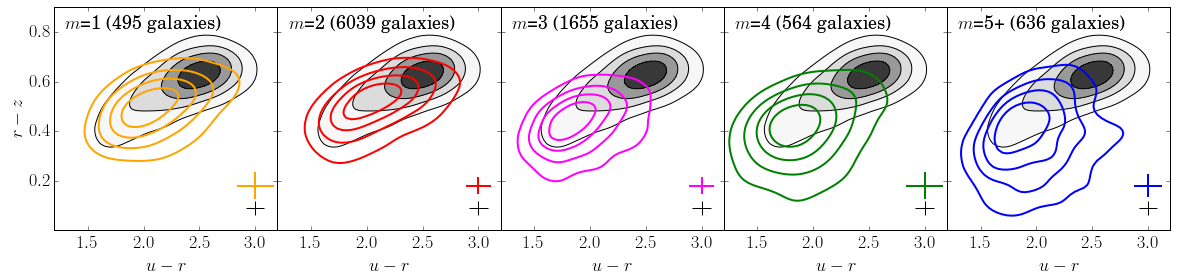

In [22]:
fig,axarr = plt.subplots(1,5,figsize=(20,4),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
axarr = axarr.ravel()
#fig.delaxes(axarr[-1])

contour(ml_data,u_cc[0],x,y,axarr,x_range=xr,y_range=yr,filled=True)

for m in range(5):
    spirals_m = ml_spirals[ml_assignments == m]
    ax = axarr[m]
    bandwidth = u_cc[m+1]
    contour(spirals_m,bandwidth,x,y,ax,colour=colors_long[m],filled=False,x_range=xr,y_range=yr)
    
ax.set_xlim([1.2,3.2])
ax.set_ylim([0,0.9])

for m in range(5):
    spirals_m = ml_spirals[ml_assignments == m]
    ax = axarr[m]
    bandwidth = u_cc[m+1]
    
    label = questions['t11_arms_number']['answerlabels'][m]
    n_gal = len(spirals_m)
    ax.text(0.05,0.9,'$m$={} ({} galaxies)'.format(label,n_gal),transform=ax.transAxes)
    
    plot_bandwidth(spirals_m,x,y,axarr[m],[0.9,0.2],bandwidth,linewidth=2,colour=colors_long[m])
    plot_bandwidth(ml_data,x,y,axarr[m],[0.9,0.1],u_cc[0])

axarr[0].set_ylabel('$r-z$')
    
for ax in axarr:
    ax.set_xlabel('$u-r$')
    
ax.set_yticks([0.2,0.4,0.6,0.8])

plt.savefig('Plotting_codes/figures/cc1.pdf')

In [70]:
xr = [9.5,12]
yr = [0,1.5]

x = ['LOGMSTAR_BALDRY06']
y = ['PETROMAG_MG','PETROMAG_MI']

u_cm = get_bandwidth_list(vl_spirals,vl_spirals,vl_assignments,
                          x,y,x_range=xr,y_range=yr)

94.0 seconds in total


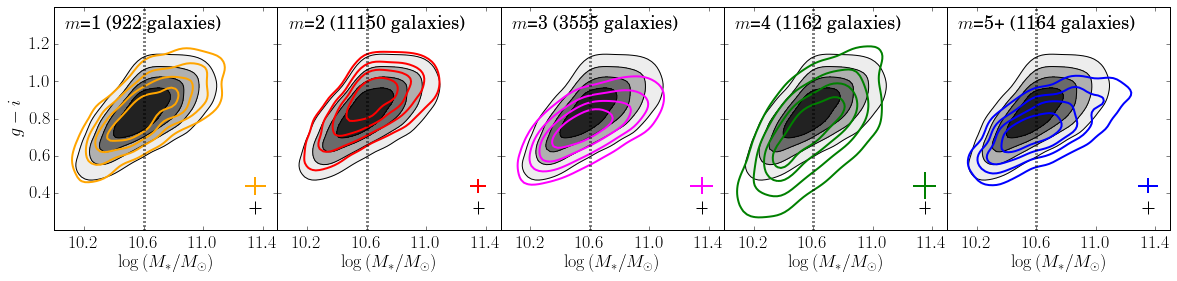

In [78]:
fig,axarr = plt.subplots(1,5,figsize=(20,4),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
axarr = axarr.ravel()
#fig.delaxes(axarr[-1])

contour(vl_spirals,u_cm[0],x,y,axarr,x_range=xr,y_range=yr,filled=True)

for m in range(5):
    spirals_m = vl_spirals[vl_assignments == m]
    ax = axarr[m]
    bandwidth = u_cm[m+1]
    contour(spirals_m,bandwidth,x,y,ax,colour=colors_long[m],filled=False,x_range=xr,y_range=yr)
    
ax.set_xlim([10,11.5])
ax.set_ylim([0.2,1.4])

for m in range(5):
    spirals_m = vl_spirals[vl_assignments == m]
    ax = axarr[m]
    bandwidth = u_cm[m+1]
    
    label = questions['t11_arms_number']['answerlabels'][m]
    n_gal = len(spirals_m)
    ax.text(0.05,0.9,'$m$={} ({} galaxies)'.format(label,n_gal),transform=ax.transAxes)
    
    plot_bandwidth(spirals_m,x,y,axarr[m],[0.9,0.2],bandwidth,linewidth=2,colour=colors_long[m])
    plot_bandwidth(ml_data,x,y,axarr[m],[0.9,0.1],u_cm[0])

axarr[0].set_ylabel('$g-i$')
    
for ax in axarr:
    ax.set_xlabel('$\log{(M_*/M_{\odot})}$')
    ax.vlines(10.6,0.2,1.4,color='k',linewidth=3,linestyle='dotted')
    
#ax.set_yticks([0.2,0.4,0.6,0.8])
ax.set_xticks([10.2,10.6,11.0,11.4])

plt.savefig('Plotting_codes/figures/cm.pdf')

# SFH

Now attempt to add SFH t-tau lines:

sfh_values: input values dictionary 
mags_all: output array w. [n_filters,n_z,n_t,n_dusts,n_taus,n_metallicities]

In [ ]:
sfh_values = pickle.load(open('../smpy-ross/values.p','rb'),encoding='latin1')
mags_all = np.load('../smpy-ross/smpy_synmag_output.mags.npy')
axes = ['filter', 'redshift', 'tg', 'Av', 'tau', 'metallicity']
axes = dict(zip(axes, range(len(axes))))

In [ ]:
def take_nearest(axisname, val, array, values=sfh_values):
  
    '''Tool for selecting nearest value in your array.
    Axis name: name of column to match.
    val: find nearest value to val.
    array: input array
    '''
    idx = (np.abs(values[axisname] - val)).argmin()
    return array.take([idx], axis=axes[axisname])

In [ ]:
mags_all = mags_all
# restframe (redshift = 0)
mags_all = take_nearest('redshift', 0.0, mags_all)
# solar metallicity
mags_all = take_nearest('metallicity', 0.02, mags_all)

In [ ]:
def age_line(x, y, val, color, label=r'$\tau$', lw=3):

    '''x,y: x and y values to plot eg. u-r,r-z
    color: line colour to plot'''
  
    plt.plot(x, y, '-', color=color, lw=lw,
             label=r'{} = {}'.format(label, val),
             zorder=1)
    plt.scatter(x, y, c=np.log10(sfh_values['tg']), s=50, zorder=2)
    
    return None


def color_color_age_line_par(par,val,mags,colour1,colour2,linecolor='k',label=r'$\tau$',
                             values=sfh_values):
  
    colxb = modify_string_name(colour1[0])
    colxr = modify_string_name(colour1[1])
    colyb = modify_string_name(colour2[0])
    colyr = modify_string_name(colour2[1])
    
    mags = take_nearest(par, val, mags)
    
    #print(mags)
    f = values['filter']
    colx = mags[f == colxb] - mags[f == colxr]
    coly = mags[f == colyb] - mags[f == colyr]
    colx = colx.squeeze()
    coly = coly.squeeze()
    age_line(colx, coly, val, linecolor, label) 
    
    return None


def dust_arrow_plot(val,mags,colour1,colour2):
  
    mags_Av0 = take_nearest('Av', 0.0, mags)
    mags_Av1 = take_nearest('Av', val, mags)
    dmag = mags_Av1 - mags_Av0
    dmag = dmag.squeeze()
    # get rid of nans
    dmag = dmag[:, ~np.isnan(dmag[0])]
    u, g, r, i, z = dmag.mean(axis=1)
    grAv1mag = (string_to_var(s=colour1[0],u=u,g=g,r=r,i=i,z=z) 
        - string_to_var(s=colour1[1],u=u,g=g,r=r,i=i,z=z))
    riAv1mag = (string_to_var(s=colour2[0],u=u,g=g,r=r,i=i,z=z) 
        - string_to_var(s=colour2[1],u=u,g=g,r=r,i=i,z=z))
    
    xy0 = (0.05,0.2)
    xy1 = (0 + grAv1mag, 0.2 + riAv1mag)
    
    arrow = plt.annotate("", xy=xy1, xytext=xy0,
        arrowprops=dict(frac=0.1, width=2,facecolor='g'))
    plt.text(xy1[0], xy1[1], '$A_v = {{{}}}$ mag'.format(str(val)), ha='left',# va='bottom',
        fontsize='small')
    
    return None

In [ ]:
def modify_string_name(s):
  
    if s == "u":
        s = b"u"
    elif s == "g":
        s = b"g"
    elif s == "r":
        s = b"r"
    elif s == "i":
        s = b"i"
    elif s == "z":
        s = b"z"
        
    return s
  
    
def string_to_var(s,u,g,r,i,z):
    
    if s == "u":
        n = u
    elif s == "g":
        n = g
    elif s == "r":
        n = r
    elif s == "i":
        n = i 
    elif s == "z":
        n = z
        
    return n 

In [ ]:
def plot_line(vary,taus,Avs,dust_arrow,colour1,colour2,colourbar=False,legend=True):
    '''vary: can vary either dust (Av) or tau
    
    '''

    c = -1
    
    #colours = ['r','g','b','orange','m']
    colours = ['black','yellow','green']
        
    if vary == "Av":
        mags = take_nearest("tau",taus[0],mags_all)
        label = "$A_v$"
        
        for v in Avs:
            c=c+1
            color_color_age_line_par("Av",Avs[c], mags
                ,colour1=colour1,colour2=colour2,linecolor=colours[c],label=label)
            
    else:
        mags = take_nearest("Av",Avs[0],mags_all)
        label = r"$\tau$"
        
        if vary != "tau":
            print("Invalid 'vary' value; using tau")
            
        for v in taus:
            c=c+1
            color_color_age_line_par("tau",taus[c], mags
                ,colour1=colour1,colour2=colour2,linecolor=colours[c],label=label)
    
    if colourbar == True:
      
        cb=plt.colorbar()
        cb.ax.set_ylabel('$\log(age [Gyr])$')
    
    if legend == True:
        plt.legend(loc = 'upper left', fontsize='small')
            
    if dust_arrow != None:
        dust_arrow_plot(val=dust_arrow,mags=mags_all,colour1=colour1,colour2=colour2)
            
    return None        

# SFH + colour-colour

In [ ]:
taus = [0.1,0.5,2.0]

In [ ]:
fig,axarr = plt.subplots(2,3,figsize=(20,20*(2/3)),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
axarr = axarr.ravel()
fig.delaxes(axarr[-1])

#contour(ml_data,u_cm[0],x,y,axarr,x_range=xr,y_range=yr,filled=True)

for m in range(5):
    spirals_m = ml_spirals[ml_assignments == m]
    ax = axarr[m]
    bandwidth = u_cc[m+1]
    contour(spirals_m,bandwidth,x,y,ax,colour=colors_long[m],filled=False,x_range=xr,y_range=yr)
    
ax.set_xlim([0.5,3.5])
ax.set_ylim([0,1])

for m in range(5):
    spirals_m = ml_spirals[ml_assignments == m]
    ax = axarr[m]
    bandwidth = u_cc[m+1]
    plot_bandwidth(spirals_m,x,y,axarr[m],[0.9,0.9],bandwidth,linewidth=2,colour=colors_long[m])
    plot_bandwidth(ml_data,x,y,axarr[m],[0.9,0.8],u_cc[0])
    
    plt.sca(ax)
    plot_line('tau',taus,taus,dust_arrow=0.4,
          colour1=['u','r'],colour2=['r','z']
              ,colourbar=False,legend=False)
    
for ax in [axarr[0],axarr[3]]:
    ax.set_ylabel('$r-z$')
axarr[4].set_xlabel('$u-r$')

In [ ]:
bw_posns = [[0.9,0.9],[0.9,0.75]]
fills = [False,True]
linewidths=[2,1]
cmaps = ['Reds','Blues']

ax = plt.figure(figsize=(10,8))
ax = plt.subplot(111)

for mi,m in enumerate([1,4]):
    spirals_m = ml_spirals[ml_assignments == m]
    bandwidth = u_cc[m+1]
    contour(spirals_m,bandwidth,x,y,ax,colour=colors_long[m],filled=fills[mi],x_range=xr,y_range=yr,
            colmap=cmaps[mi])
    
ax.set_xlim([0,3.5])
ax.set_ylim([0,0.8])

for mi,m in enumerate([1,4]):
    spirals_m = ml_spirals[ml_assignments == m]
    bandwidth = u_cc[m+1]
    
    plot_bandwidth(spirals_m,x,y,ax,bw_posns[mi],bandwidth,linewidth=linewidths[mi],
                   colour=colors_long[m])


plot_line('tau',taus,taus,dust_arrow=0.4,
          colour1=['u','r'],colour2=['r','z'],colourbar=True)

plt.xlabel('$u-r$')
plt.ylabel('$r-z$')

plt.savefig('Plotting_codes/figures/cc1_w_sfh.pdf')